______________
DAMI2 Project Report Code - Handling unbalanced datasets

2020 Jimmy Ljungman

This code imports a data set, preprocesses it, run a new sampling technique
called 'Unbalanced_bagging' and measure its performance against other sampling techniques
such as random oversampling and random undersampling.

Unbalanced_bagging will be measured against the other techniques using the metrics AUPRC and time complexity.

______________
Importing necessary libraries and setting global variables

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from scipy.stats import mode

import random

RANDOM_SEED = 12345

>Import dataset
>
>More information about the dataset can be found here:
>https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data?select=train.csv

In [2]:
original_df = pd.read_csv("Dataset/train.csv")

X = original_df.drop('target', axis=1)
y = original_df.target

______________
Describing data

<AxesSubplot:title={'center':'Plot over class imbalance'}>

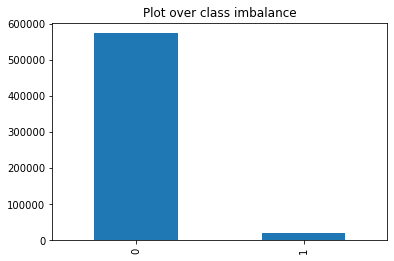

In [3]:
total_labels = original_df.target.value_counts()
total_labels.plot(kind='bar', title='Plot over class imbalance')

>As we can see, the class distribution heavily favors class 0.

In [4]:
original_df.head()


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


>- According to the source of the dataset 'id' is unique and is the id of each
>_ which means it can be dropped; especially since we are bagging with decision trees.
>- Feature names including postfix 'bin' indicate binary features.
>- Feature names including postfix 'cat' indicate categorical features.
>- Feature names without these designations are either continuos or ordinal.
>- Values of -1 indicate that the feature was missing from the observation.
>- 'Target' is the class label and signifies whether or not a claim was filed for that policy holder.

______________
Preprocessing

>Drop the 'id' column

In [5]:
X = X.drop('id', axis=1)
X.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


>Check for missing values

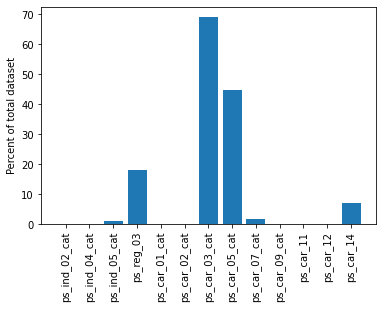

In [6]:
#https://www.kaggle.com/kostya17/simple-approach-to-handle-missing-values
def get_missing_values(data):
    dict = {}
    N = data.shape[0]
    for col in data:
        val = (data[col] == -1).sum()
        if(val > 0):
            dict[col] = val * 100 / N
    plot_missing_values(dict)
    return dict

def plot_missing_values(dict):
    plt.bar(range(len(dict)), dict.values())
    plt.ylabel('Percent of total dataset')
    plt.xticks(range(len(dict)), dict.keys(), rotation='vertical')

missing_values_dictionary = get_missing_values(X)

>We see that ps_car_03_cat and ps_car_05_cat is missing more than 45 % of their values,
>thus we should probably drop them:

In [7]:
X = X.drop('ps_car_03_cat', axis=1)
missing_values_dictionary.pop('ps_car_03_cat')
X = X.drop('ps_car_05_cat', axis=1)
missing_values_dictionary.pop('ps_car_05_cat')
X.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0


>For the rest of the features with missing values we will just fill categorical and binary features with their mode value and with
>the continous and ordinal values we'll fill the missing values with their mean value.

{}

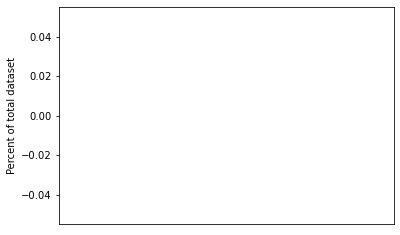

In [8]:
def remove_missing_values(data, dict):
    for key in dict:
        if any([x in key for x in ['bin', 'cat']]):
            data = data.replace({key:{-1 : data[key].mode()[0]}})
        else:
            data = data.replace({key:{-1 : data[key].mean()}})
    return data

X = remove_missing_values(X, missing_values_dictionary)
get_missing_values(X)

>All missing values has been taken care of.
>
>We can now continue with different sampling techniques:

In [12]:
X_training,X_testing,y_training,y_testing, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.3, random_state=RANDOM_SEED)

In [23]:
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

def unbalanced_dataset_technique():
    clf.fit(x_train, y_train)
    return clf

def smote_technique():
    smote = SMOTE(random_state=RANDOM_SEED,sampling_strategy='minority')
    x_sample, y_sample = smote.fit_sample(x_train, y_train)
    clf.fit(x_sample,y_sample)
    return clf

def random_oversampling_technique():
    ros = RandomOverSampler(random_state=RANDOM_SEED)
    x_sample, y_sample = ros.fit_sample(x_train, y_train)
    clf.fit(x_sample, y_sample)
    return clf

def random_undersampling_technique():
    rus = RandomUnderSampler(random_state=RANDOM_SEED)
    x_sample, y_sample = rus.fit_sample(x_train, y_train)
    clf.fit(x_sample, y_sample)
    return clf

In [17]:
#Train on original data
print("Original data")
classifier = unbalanced_dataset_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

Validation Results:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    120468
           1       0.05      0.06      0.05      4527

    accuracy                           0.92    124995
   macro avg       0.51      0.51      0.51    124995
weighted avg       0.93      0.92      0.93    124995


Test Results:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    172033
           1       0.05      0.06      0.05      6531

    accuracy                           0.92    178564
   macro avg       0.50      0.51      0.51    178564
weighted avg       0.93      0.92      0.92    178564



In [20]:
#Train on SMOTE
print("Data balanced by SMOTE")
classifier = smote_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

Data balanced by SMOTE

Validation Results:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95    120468
           1       0.05      0.09      0.06      4527

    accuracy                           0.90    124995
   macro avg       0.50      0.51      0.50    124995
weighted avg       0.93      0.90      0.92    124995


Test Results:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95    172033
           1       0.04      0.08      0.06      6531

    accuracy                           0.90    178564
   macro avg       0.50      0.51      0.50    178564
weighted avg       0.93      0.90      0.91    178564



In [21]:
#Train on Random Oversampling
print("Data balanced by Random Oversampling")
classifier = random_oversampling_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

Data balanced by Random Oversampling

Validation Results:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    120468
           1       0.04      0.04      0.04      4527

    accuracy                           0.93    124995
   macro avg       0.50      0.50      0.50    124995
weighted avg       0.93      0.93      0.93    124995


Test Results:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    172033
           1       0.04      0.05      0.05      6531

    accuracy                           0.93    178564
   macro avg       0.50      0.50      0.50    178564
weighted avg       0.93      0.93      0.93    178564



In [24]:
#Train on Random Undersampling
print("Data balanced by Random Undersampling")
classifier = random_undersampling_technique()
print("\nValidation Results:")
print(classification_report(y_val, classifier.predict(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier.predict(X_testing)))

Data balanced by Random Undersampling

Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.53      0.68    120468
           1       0.04      0.52      0.07      4527

    accuracy                           0.53    124995
   macro avg       0.50      0.53      0.38    124995
weighted avg       0.93      0.53      0.66    124995


Test Results:
              precision    recall  f1-score   support

           0       0.97      0.53      0.68    172033
           1       0.04      0.51      0.07      6531

    accuracy                           0.53    178564
   macro avg       0.50      0.52      0.38    178564
weighted avg       0.93      0.53      0.66    178564



In [32]:
#Unbalanced_bagger implementation
def unbalanced_bagger(x, y, M = 1, sampling_techniques = None):
    if sampling_techniques is None:
        sampling_techniques = []
    #M = Amount of base_learners, x = train set, y = class labels
    base_learners = []
    for i in range(M):
        #boostrap replica
        rnd = np.random.choice(x.shape[0], size=x.shape[0])
        x_bootstrap = x.iloc[rnd,:]
        y_bootstrap = y.iloc[rnd]
        #sample the replica with random sample technique
        technique = random.randint(0,len(sampling_techniques)-1)
        x_sample, y_sample = sampling_techniques[technique].fit_sample(x_bootstrap,y_bootstrap)
        #train
        clf = DecisionTreeClassifier()
        clf.fit(x_sample,y_sample)
        base_learners.append(clf)

    def predict(x):
        predictions = np.zeros([x.shape[0], len(base_learners)])
        for i in range(len(base_learners)):
            predictions[:,i] = base_learners[i].predict(x)
        return mode(predictions, axis=1)[0]
    return predict

In [33]:
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

sampling_techniques = [ros, rus,smote]
classifier = unbalanced_bagger(x_train, y_train, 10, sampling_techniques)

#Test technique
print("Data balanced by Unbalanced Bagger")
print("\nValidation Results:")
print(classification_report(y_val, classifier(x_val)))
print("\nTest Results:")
print(classification_report(y_testing, classifier(X_testing)))

Data balanced by Unbalanced Bagger

Validation Results:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    120468
           1       0.07      0.01      0.01      4527

    accuracy                           0.96    124995
   macro avg       0.52      0.50      0.50    124995
weighted avg       0.93      0.96      0.94    124995


Test Results:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172033
           1       0.08      0.01      0.02      6531

    accuracy                           0.96    178564
   macro avg       0.52      0.50      0.50    178564
weighted avg       0.93      0.96      0.94    178564

